In [ ]:
from keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from the correct location
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Set up the dataset directories
dataset_dir = '/content/drive/MyDrive/research work/dataset/train'  # Replace with your dataset directory
img_width, img_height = 224, 224
batch_size = 8
num_classes = 4

# Step 2: Data augmentation and generators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.02,
    zoom_range=0.02,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of the data for validation
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=1,  # Set batch size to 1 for testing
    class_mode='categorical',
    shuffle=False  # Do not shuffle for testing
)

# Step 3: Load the InceptionV3 model and add custom layers
from keras.applications import MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min') # Change file extension to '.keras'
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

# Step 5: Evaluate the model and generate a classification report
# Step 5: Evaluate the model and generate a classification report
model.load_weights('best_model.keras')  # Load the best model, use the correct file extension '.keras'

# ... (Rest of your code remains the same)  # Load the best model

# Predict on the test data
test_generator.reset()  # Reset the generator
predictions = model.predict(test_generator, steps=test_generator.samples, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)



Found 754 images belonging to 4 classes.
Found 186 images belonging to 4 classes.
Found 940 images belonging to 4 classes.
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5026 - loss: 1.5978
Epoch 1: val_loss improved from inf to 1.42958, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 667s 7s/step - accuracy: 0.5038 - loss: 1.5929 - val_accuracy: 0.4247 - val_loss: 1.4296
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7992 - loss: 0.5224
Epoch 2: val_loss improved from 1.42958 to 1.19686, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 29s 306ms/step - accuracy: 0.7992 - loss: 0.5220 - val_accuracy: 0.4892 - val_loss: 1.1969
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8271 - loss: 0.4173
Epoch 3: val_loss did not improve from 1.19686
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 325ms/step - accuracy: 0.8272 - loss: 0.4170 - val_accuracy: 0.4677 - val_loss: 1.3295
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8835 - loss: 0.2620
Epoch 4: val_loss did not improve from 1.19686
95/95 ━━━━━━━━━━━━━━━━━━━━ 28s 300ms/step - acc

940/940 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step


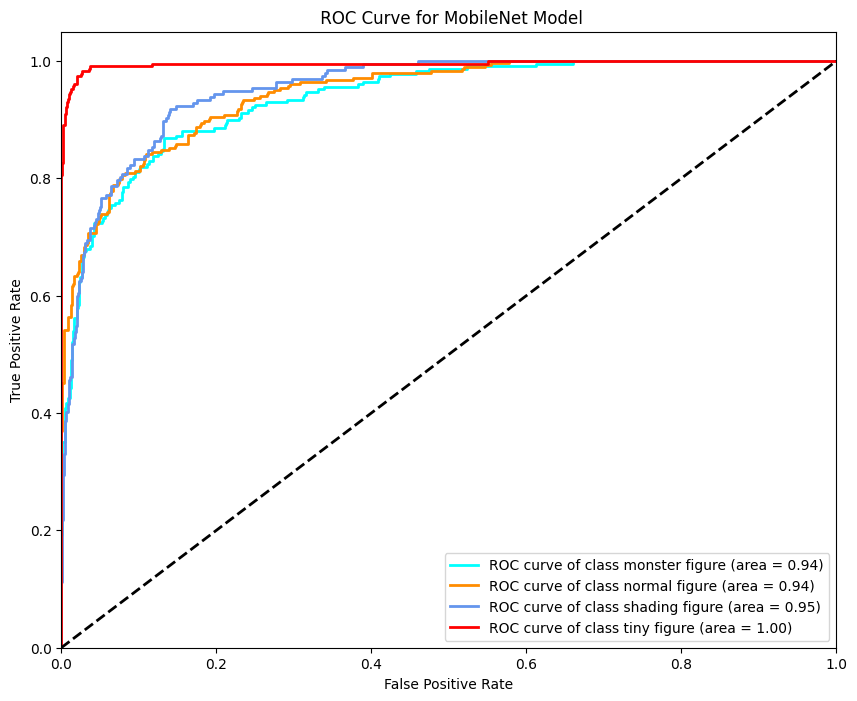


AUC Scores per Class:
Class monster figure: 0.94
Class normal figure: 0.94
Class shading figure: 0.95
Class tiny figure: 1.00


In [ ]:
# prompt: plz generate code for ROC AUC Scores and also visualize it

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 6: Calculate and visualize ROC curves and AUC scores

# Predict probabilities for ROC curve
test_generator.reset()
y_pred_proba = model.predict(test_generator, steps=test_generator.samples, verbose=1)

# Get true labels (one-hot encoded)
y_true = test_generator.classes
y_true_onehot = np.eye(num_classes)[y_true]

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' ROC Curve for MobileNet Model')
plt.legend(loc="lower right")
plt.show()

# Print AUC scores for each class
print("\nAUC Scores per Class:")
for i in range(num_classes):
    print(f"Class {class_labels[i]}: {roc_auc[i]:0.2f}")


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Reset test generator
test_generator.reset()

# Predict on the test set
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)




940/940 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step
                precision    recall  f1-score   support

monster figure       0.79      0.84      0.81       228
 normal figure       0.79      0.85      0.82       284
shading figure       0.91      0.74      0.82       197
   tiny figure       0.96      0.98      0.97       231

      accuracy                           0.86       940
     macro avg       0.86      0.85      0.86       940
  weighted avg       0.86      0.86      0.85       940



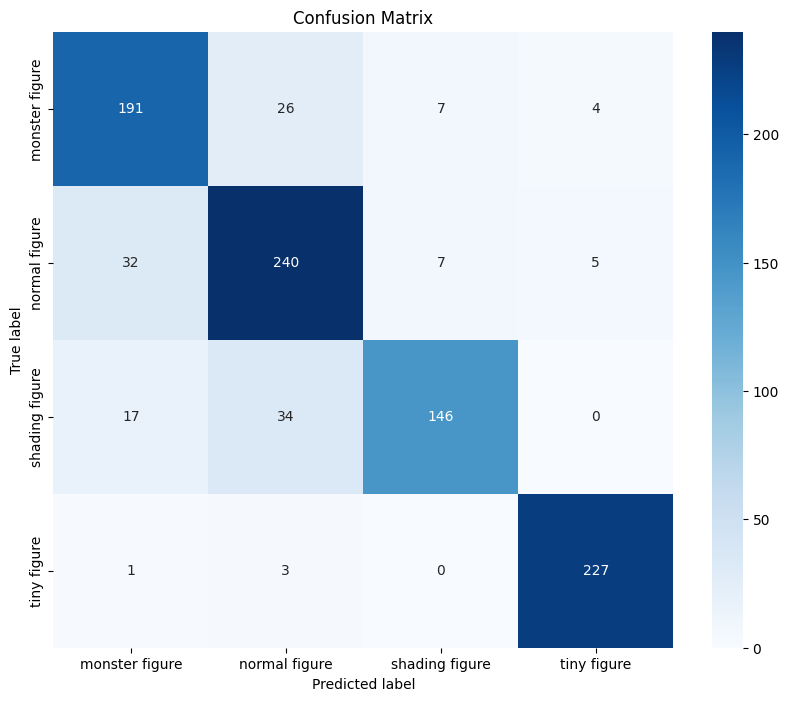

In [ ]:
# prompt: plz show the confussion metrics of this model

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()